In [1]:
import numpy as np
import scipy as sp
import netCDF4 as nC4
import scipy.signal
import nc_time_axis
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
import seaborn as sn
sn.set_context("paper",font_scale=1.2)
import cartopy
from cartopy import crs
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import cartopy.feature as cfeature
import xarray as xr
import xskillscore as xs
import os
import pandas as pd
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import sys
import glob
import datetime
import time
import multiprocessing
import zipfile
import palettable
import copy

# get my own stats functions
from mystatsfunctions import OLSE,LMoments
from moarpalettes import get_palette

from IPython.display import display, clear_output

%matplotlib inline

In [2]:
## matplotlib RCparams setup

matplotlib.rcParams['axes.prop_cycle']=matplotlib.cycler('color',list(get_palette.Petroff10().to_sn_palette()))
matplotlib.rcParams['font.family']='Helvetica Neue'
matplotlib.rcParams['legend.frameon']=False
plt.rcParams['pdf.fonttype'] = 42

In [3]:
## plotting functions:

def add_lat_lon_ticks(ax,lat=True,lon=True, lon_ext=[-180,181], lat_ext=[-90,91]):
    if lon:
        ax.set_xticks(np.arange(*lon_ext,30), crs=crs.PlateCarree())
        lon_formatter = LongitudeFormatter(zero_direction_label=True)
        ax.xaxis.set_major_formatter(lon_formatter)
    if lat:
        ax.set_yticks(np.arange(*lat_ext,10), crs=crs.PlateCarree())
        lat_formatter = LatitudeFormatter()
        ax.yaxis.set_major_formatter(lat_formatter)

### get meta & lsm for ExSamples, UKCP

In [4]:
## ExSamples data location:
ExS_dataloc = '../../ExSamples_product/20210622/'

## create a run_info dataframe
run_info = pd.DataFrame(data=[['05','10','15'],['2072','2068','2066'],['r001i1p01554','r001i1p02242','r001i1p02868'],['hot','wet','hot']],
                        index=['ensemble_member','year','run','type'],columns=['fut_2072','fut_2068','fut_2066']).T

run_info['label'] = ['HOT2','WET','HOT1']

## get land sea masks
ExS_GBR_lsm = xr.open_dataarray('../ancil/ExS_GBR_lsm.nc')
UKCP_GBR_lsm = xr.open_dataarray('../ancil/UKCP_GBR_lsm.nc',decode_times=False)
UKCP_glob_lsm = xr.open_dataarray('../ancil/UKCP_lsm.nc',decode_times=False).astype(bool)

## create a dict of UKCP PPE experiment subsamples
UKCP_experiment_list = {}
UKCP_experiment_list[10] = ['0000','1113','1554','1649','1843','1935','2123','2242','2491','2868']
UKCP_experiment_list[12] = ['0000','1113','1554','1649','1843','1935','2123','2242','2305','2335','2491','2868']
UKCP_experiment_list[15] = ['0000', '0605', '0834', '1113', '1554', '1649', '1843', '1935', '2123', '2242', '2305', '2335', '2491', '2832', '2868']
UKCP_experiment_list[13] = ['0000', '0605', '0834', '1113', '1554', '1649', '1843', '1935', '2123', '2242', '2491', '2832', '2868']
UKCP_experiment_list[20] = ['0000', '0090', '0605', '0834', '1113', '1554', '1649', '1843', '1935', '2089', '2123', '2242', '2305', '2335', '2491', '2753', '2832', '2868', '2884', '2914']

## create a colour palette if required.
choose_palette = [matplotlib.colors.to_hex(get_palette.IBM_color_blind().to_sn_palette()[i]) for i in [2,0,3]]

## other options:
### IBM color blind
# [matplotlib.colors.to_hex(get_palette.IBM_color_blind().to_sn_palette()[i]) for i in [2,0,3]]
### Petroff 6
# [matplotlib.colors.to_hex(get_palette.Petroff6().to_sn_palette()[i]) for i in [1,0,2]]
### tab10
# [matplotlib.colors.to_hex(get_palette.tab10().to_sn_palette()[i]) for i in [1,0,2]]

winter_colors = pd.Series(index=['1554','2242','2868'],data=choose_palette)

## Get data

UKCP pr data

In [5]:
## get UKCP precip
def preproc_UKCP_precip(ds):
    # selects DJF & averages over
    realization = str(ds.realization.values[()])
    ensemble_member_id = 'r00'+realization[0]+'i'+realization[1]+'p'+realization[2:]
    if not ensemble_member_id[-4:] in UKCP_experiment_list[15]:
        return None
    ds = ds.expand_dims('realization').rename(dict(realization='ensemble_member_id',precipitation_flux='pr')).assign_coords(ensemble_member_id=[ensemble_member_id])
    return ds

UKCP_precip_scaling = 1000/997*(3600*24) # convert to mm -> per day

UKCP_pr = xr.concat([x.chunk({'ensemble_member_id':1}) for x in [preproc_UKCP_precip(xr.open_dataset(x)) for x in sorted(glob.glob('/home/users/njleach/UKCP_hadgem3_data/pr/*.nc'))] if x is not None],'ensemble_member_id')*UKCP_precip_scaling

In [6]:
# convert to seasonal mean timeseries
UKCP_prm = UKCP_pr.resample(time='QS-DEC').mean()
UKCP_prm = UKCP_prm.sel(time=UKCP_prm['time.month']==12)

/home/users/njleach/miniconda3/lib/python3.9/site-packages/dask/array/core.py:4337: PerformanceWarning: Increasing number of chunks by factor of 15
  result = blockwise(


In [7]:
## average over UK land:
UKCP_GBR_lsm_slice = UKCP_GBR_lsm.sel(latitude=slice(50,61),longitude=slice(-12,2)).assign_coords(latitude=UKCP_prm.latitude,longitude=UKCP_prm.longitude)

UKCP_prm_df = UKCP_prm.pr.where(UKCP_GBR_lsm_slice).weighted(np.cos(np.deg2rad(UKCP_GBR_lsm_slice.latitude))).mean(['latitude','longitude']).to_pandas()
# set columns equal to 4-digit member code
UKCP_prm_df.columns = [x[-4:] for x in UKCP_prm_df.columns]
# set index equal to years (ie. the JF year)
UKCP_prm_df.index = np.arange(1900,2100)

get max pr too

In [8]:
## convert UKCP_pr to seasonal max timeseries
UKCP_prx = UKCP_pr.resample(time='QS-DEC').max()
UKCP_prx = UKCP_prx.sel(time=UKCP_prx['time.month']==12)

/home/users/njleach/miniconda3/lib/python3.9/site-packages/dask/array/core.py:4337: PerformanceWarning: Increasing number of chunks by factor of 15
  result = blockwise(


In [9]:
UKCP_prx_df = UKCP_prx.pr.where(UKCP_GBR_lsm_slice).weighted(np.cos(np.deg2rad(UKCP_GBR_lsm_slice.latitude))).mean(['latitude','longitude']).to_pandas()
# set columns equal to 4-digit member code
UKCP_prx_df.columns = [x[-4:] for x in UKCP_prx_df.columns]
# set index equal to years (ie. the JF year)
UKCP_prx_df.index = np.arange(1900,2100)

ExSamples data

In [10]:
ExS_GBR_lsm_slice = ExS_GBR_lsm.sel(latitude=slice(62,48),longitude=slice(-13,5))

In [11]:
def preproc_ExS_pr(ds):
    # squeeze out unwanted dimensions
    ds = ds.squeeze()
    # rename default output names to conventional ones
    ds = ds.rename({'latitude2':'latitude','longitude2':'longitude','time1':'time','item5216_6hrly_mean':'pr'})
    # select DJF only
    ds = ds.sel(time=ds['time.month'].isin([12,1,2]))
    # ensure spatial coords match the lsm exactly
    ds = ds.assign_coords(latitude=ExS_GBR_lsm_slice.latitude,longitude=ExS_GBR_lsm_slice.longitude) 
    
    ## check for excessive values + print those members:
    if ds.ensemble_member_id.sel(ensemble_member_id=(UKCP_precip_scaling*ds.pr.mean(['latitude','longitude'])>100).any('time')).values.size:
        print(ds.ensemble_member_id.sel(ensemble_member_id=(UKCP_precip_scaling*ds.pr.mean(['latitude','longitude'])>100).any('time')).values[0])
    
    return ds

def preproc_ExS_maxpr(ds):
    ds = preproc_ExS_pr(ds).pr
    # take time maximum at each gridpoint
    ds = ds.max('time')
    # average over UK land
    ds = ds.where(ExS_GBR_lsm_slice).weighted(np.cos(np.deg2rad(ExS_GBR_lsm_slice.latitude))).mean(['latitude','longitude'])
    return ds.to_pandas() * UKCP_precip_scaling

def preproc_ExS_meanpr(ds):
    ds = preproc_ExS_pr(ds).pr    
    # take time mean at each gridpoint
    ds = ds.mean('time')
    # average over UK land
    ds = ds.where(ExS_GBR_lsm_slice).weighted(np.cos(np.deg2rad(ExS_GBR_lsm_slice.latitude))).mean(['latitude','longitude'])
    return ds.to_pandas() * UKCP_precip_scaling

def get_mean_max_pr(path):
    ds = xr.open_dataset(path)
    return [preproc_ExS_meanpr(ds),preproc_ExS_maxpr(ds)]
    
ExS_1554_fut = pd.concat(get_mean_max_pr(ExS_dataloc+'HotWinter2072-r001i1p01554/UK/pr_daily/HotWinter2072-r001i1p01554_pr_daily_UK_members0000-0908.nc'),axis=1,keys=['prm','prx'])
ExS_2242_fut = pd.concat(get_mean_max_pr(ExS_dataloc+'WetWinter2068-r001i1p02242/UK/pr_daily/WetWinter2068-r001i1p02242_pr_daily_UK_members0000-0945.nc'),axis=1,keys=['prm','prx'])
ExS_2868_fut = pd.concat(get_mean_max_pr(ExS_dataloc+'HotWinter2066-r001i1p02868/UK/pr_daily/HotWinter2066-r001i1p02868_pr_daily_UK_members0000-1032.nc'),axis=1,keys=['prm','prx'])

ExS_1554_base = pd.concat([pd.concat(get_mean_max_pr(x),axis=1,keys=['prm','prx']) for x in glob.glob(ExS_dataloc+'BaselineWinters/UK/pr_daily/*1554*.nc')],axis=0)
ExS_2242_base = pd.concat([pd.concat(get_mean_max_pr(x),axis=1,keys=['prm','prx']) for x in glob.glob(ExS_dataloc+'BaselineWinters/UK/pr_daily/*2242*.nc')],axis=0)
ExS_2868_base = pd.concat([pd.concat(get_mean_max_pr(x),axis=1,keys=['prm','prx']) for x in glob.glob(ExS_dataloc+'BaselineWinters/UK/pr_daily/*2868*.nc')],axis=0)

/home/users/njleach/miniconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:87: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/users/njleach/miniconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:87: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


8871467


/home/users/njleach/miniconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:87: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/users/njleach/miniconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:87: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/users/njleach/miniconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:87: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


8871467
8971144
8971144


/home/users/njleach/miniconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:87: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/users/njleach/miniconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:87: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


8831506


/home/users/njleach/miniconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:87: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/users/njleach/miniconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:87: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/users/njleach/miniconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:87: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


8831506


In [12]:
## concatenate for easy functional coding
ExS_fut = pd.concat([ExS_1554_fut,ExS_2242_fut,ExS_2868_fut],keys=['1554','2242','2868'])
ExS_base = pd.concat([ExS_1554_base,ExS_2242_base,ExS_2868_base],keys=['1554','2242','2868'])

In [13]:
## remove the members found above to have dodgy precip
ExS_fut.drop([8871467,8971144,8831506],level=1,inplace=True)

Slice out the analogs from each ensemble

In [15]:
analog_list = pd.read_csv('../output/data/manuscript-analogs.csv')['0'].values

In [16]:
ExS_fut_analogs = ExS_fut.reindex(set(analog_list).intersection(ExS_fut.index.levels[1]),level=1)
ExS_base_analogs = ExS_base.reindex(set(analog_list).intersection(ExS_base.index.levels[1]),level=1)

## Analyse and create figure

preprocess UKCP 2061-2080

In [17]:
prm_olse = OLSE.simple(UKCP_prm_df.loc[2061:2080])
prm_olse.fit(np.arange(20)[:,None])

UKCP_prm_detrend_df = (pd.DataFrame().reindex_like(UKCP_prm_df.loc[2061:2080]).fillna(0) + prm_olse.res.data)
UKCP_prm_detrend_df -= UKCP_prm_detrend_df.mean()

prx_olse = OLSE.simple(UKCP_prx_df.loc[2061:2080])
prx_olse.fit(np.arange(20)[:,None])

UKCP_prx_detrend_df = (pd.DataFrame().reindex_like(UKCP_prx_df.loc[2061:2080]).fillna(0) + prx_olse.res.data)
UKCP_prx_detrend_df -= UKCP_prx_detrend_df.mean()

In [18]:
## concat for easy functional programming
UKCP_detrend_df = pd.concat([UKCP_prm_detrend_df,UKCP_prx_detrend_df],axis=1,keys=['prm','prx'])
UKCP_df = pd.concat([UKCP_prm_df,UKCP_prx_df],axis=1,keys=['prm','prx'])

In [19]:
## preproecssing definition:

def preproc_data_for_fig(select_winter,var='prm',percent=False,analogs=False):
    
    # get info about chosen winter
    ensmem,year,run,extreme,label = run_info.loc[select_winter].values
    
    # set the UKCP 2061-80 deviations population relative to the difference between the UKCP baseline average temp and the UKCP 10-year window average centered on the chosen winter
    UKCP_fut_pop = UKCP_detrend_df[var].values.flatten() - UKCP_df[var].loc[2007:2016].values.mean() + UKCP_df[var].loc[int(year)-5:int(year)+5].values.mean()
    # set the UKCP baseline relative to its own average
    UKCP_base_pop = (UKCP_df[var].loc[2007:2016] - UKCP_df[var].loc[1997:2026].mean()).values.flatten()
    
    ExS_fut_pop = ExS_fut.loc[run[-4:],var].values - ExS_base.loc[run[-4:],var].values.mean()
    ExS_base_pop = ExS_base.loc[run[-4:],var].values - ExS_base.loc[run[-4:],var].values.mean()
    
    if percent:
        UKCP_fut_pop *= 100 / UKCP_df[var].loc[2007:2016].values.mean()
        UKCP_base_pop = 100*((UKCP_df[var].loc[2007:2016] - UKCP_df[var].loc[1997:2026].mean())/UKCP_df[var].loc[1997:2026].mean()).values.flatten()
        
        ExS_fut_pop *= 100 / ExS_base.loc[run[-4:],var].values.mean()
        ExS_base_pop *= 100 / ExS_base.loc[run[-4:],var].values.mean()
        
    if analogs:
        ExS_fut_pop_analogs = ExS_fut_analogs.loc[run[-4:],var].values - ExS_base.loc[run[-4:],var].values.mean()
        ExS_base_pop_analogs = ExS_base_analogs.loc[run[-4:],var].values - ExS_base.loc[run[-4:],var].values.mean()
        
        if percent:
            ExS_fut_pop_analogs *= 100 / ExS_base.loc[run[-4:],var].values.mean()
            ExS_base_pop_analogs *= 100 / ExS_base.loc[run[-4:],var].values.mean()
            
        return UKCP_fut_pop, UKCP_base_pop, ExS_fut_pop, ExS_base_pop, ExS_fut_pop_analogs, ExS_base_pop_analogs
    
    return UKCP_fut_pop, UKCP_base_pop, ExS_fut_pop, ExS_base_pop

create distribution features shown in figure

In [20]:
### write definition for carrying out the computating automatically

def create_main_fig(select_winter,var='prm',statmodel=LMoments.gpd):
    
    ## select_winter is one of [fut_2066, fut_2068, fut_2072]
    
    ensmem,year,run,extreme,label = run_info.loc[select_winter].values
    
    UKCP_fut_pop, UKCP_base_pop, ExS_fut_pop, ExS_base_pop, ExS_fut_pop_analogs, ExS_base_pop_analogs = preproc_data_for_fig(select_winter,var=var,percent=True,analogs=True)
    
    # use first definition for ANOMALIES, second for deviations
#     UKCP_selected_winter = (UKCP_df.loc[int(year),(var,run[-4:])] - UKCP_df.loc[1997:2026,(var,run[-4:])].mean()) / UKCP_df.loc[1997:2026,(var,run[-4:])].mean() * 100
    UKCP_selected_winter = (UKCP_detrend_df.loc[int(year),(var,run[-4:])] - UKCP_df[var].loc[2007:2016].values.mean() + UKCP_df[var].loc[int(year)-5:int(year)+5].values.mean()) / UKCP_df[var].loc[2007:2016].values.mean() * 100
    
    if statmodel == LMoments.gpd:
        
        gpd_threshold = 0.75
        
    else:
        
        gpd_threshold = 0
        
    UKCP_statmodel = statmodel()
    UKCP_statmodel.fit(UKCP_fut_pop[UKCP_fut_pop>=np.quantile(UKCP_fut_pop,gpd_threshold)])

    ## calculate ExSamples statistical CDF
    ExS_CDF = np.where( ExS_fut_pop >= np.quantile(UKCP_fut_pop,gpd_threshold) , gpd_threshold + UKCP_statmodel.cdf(ExS_fut_pop)*(1-gpd_threshold) , (ExS_fut_pop[None]>UKCP_fut_pop[:,None]).sum(axis=0) / UKCP_fut_pop.size )
    ExS_RP = 1/(1-ExS_CDF)

    ## calculate UKCP statistical CDF
    UKCP_CDF = np.where( UKCP_fut_pop >= np.quantile(UKCP_fut_pop,gpd_threshold) , gpd_threshold + UKCP_statmodel.cdf(UKCP_fut_pop)*(1-gpd_threshold) , (UKCP_fut_pop[None]>UKCP_fut_pop[:,None]).sum(axis=0) / UKCP_fut_pop.size )
    UKCP_RP = 1/(1-UKCP_CDF)

    UKCP_ECDF = (UKCP_fut_pop[None]>UKCP_fut_pop[:,None]).sum(axis=0) / UKCP_fut_pop.size
    UKCP_ERP = 1/(1-UKCP_ECDF)
    
    ## bootstrap the statistical model for 5-95 curves
    n_boot=10000
    
    ## create bootstrap samples + select members above quantile selected
    UKCP_fut_pop_boot = UKCP_fut_pop[np.random.choice(UKCP_fut_pop.size,UKCP_fut_pop.size*n_boot)].reshape(UKCP_fut_pop.size,-1)
    UKCP_fut_pop_boot = np.take_along_axis(UKCP_fut_pop_boot,UKCP_fut_pop_boot.argsort(axis=0),axis=0)[-int(np.ceil(UKCP_fut_pop_boot.shape[0]*(1-gpd_threshold))):]

    ## initialise a new distribution object
    UKCP_statmodel_boot = statmodel()
    ## and fit to each resample
    UKCP_statmodel_boot.fit(UKCP_fut_pop_boot)
    
    # create xrange for statmodel curve
    UKCP_statmodel_xrange = np.arange(np.quantile(UKCP_fut_pop,gpd_threshold),np.ceil(ExS_fut_pop.max()*1.2),0.01)
    UKCP_statmodel_CDF = UKCP_statmodel_boot.cdf(UKCP_statmodel_xrange[:,None])
    
    ## create colors:

    base_color = winter_colors.loc[run[-4:]]
    dark_color = matplotlib.colors.to_hex(tuple(np.divide(matplotlib.colors.to_rgb(base_color),1.5)))

    base_grey = 'xkcd:grey'
    dark_grey = 'xkcd:dark grey'
    
    ## create figure
    
    fig = plt.figure(figsize=(9,9))
    gs = fig.add_gridspec(2,2,hspace=0.3,wspace=0.3)
    dist_gs = gs[0,:].subgridspec(12,1,hspace=0,wspace=0)

    sample_ax = fig.add_subplot(gs[1,1],zorder=2)
    dist_ax = fig.add_subplot(dist_gs[:,0],zorder=2)
    ana_dist_ax = fig.add_subplot(dist_gs[0,0],zorder=3)
    rp_ax = fig.add_subplot(gs[1,0],zorder=1)

    ## plot distributions
    ### future distributions
    sn.kdeplot(x=UKCP_fut_pop,ax=dist_ax,color=base_color,lw=2,label='UKCP 2061-2080 ('+str((UKCP_fut_pop>UKCP_selected_winter).sum())+'/'+str(UKCP_fut_pop.size)+')')
    sn.kdeplot(x=ExS_fut_pop,ax=dist_ax,color=dark_color,lw=2,label=label+' ensemble ('+str((ExS_fut_pop>UKCP_selected_winter).sum())+'/'+str(ExS_fut_pop.size)+')')

    ### baseline distributions
    sn.kdeplot(x=UKCP_base_pop,ax=dist_ax,color=base_grey,lw=2,label='UKCP 2007-2016 ('+str((UKCP_base_pop>UKCP_selected_winter).sum())+'/'+str(UKCP_base_pop.size)+')')
    sn.kdeplot(x=ExS_base_pop,ax=dist_ax,color=dark_grey,lw=2,label=label+'-B ensemble ('+str((ExS_base_pop>UKCP_selected_winter).sum())+'/'+str(ExS_base_pop.size)+')')

    ### analog distributions for txm
    if var=='prm':
        
        ana_dist_ax.plot(np.quantile(ExS_fut_pop_analogs,[0.16,0.84]),[1,1],color=dark_color,lw=2,clip_on=False)
        ana_dist_ax.plot(np.mean(ExS_fut_pop_analogs),1,color=dark_color,marker='o',lw=2,clip_on=False)
        ana_dist_ax.plot(np.quantile(ExS_base_pop_analogs,[0.16,0.84]),[0,0],color=dark_grey,lw=2,clip_on=False)
        ana_dist_ax.plot(np.mean(ExS_base_pop_analogs),0,color=dark_grey,marker='o',lw=2,clip_on=False)
        
        ## set xlimits to more aesthetic limits
        ana_dist_ax.set_ylim(-2.5,1.5)
        
        ## add threshold value
#         ana_dist_ax.axhline(UKCP_selected_winter, ls='--', color=base_color, lw=1.5)
        
        dist_ax.plot([],[],color=dark_color,marker='o',lw=2,label=label+' ensemble analogs ('+str((ExS_fut_pop_analogs>UKCP_selected_winter).sum())+'/'+str(ExS_fut_pop_analogs.size)+')')
        dist_ax.plot([],[],color=dark_grey,marker='o',lw=2,label=label+'-B ensemble analogs ('+str((ExS_base_pop_analogs>UKCP_selected_winter).sum())+'/'+str(ExS_base_pop_analogs.size)+')')
    
    ### threshold value
    dist_ax.axvline(UKCP_selected_winter, ls='--', color=base_color, lw=1.5, label=label+' winter')

    ## plot return period diagram
    ### empirical sample
    rp_ax.semilogx(UKCP_ERP,UKCP_fut_pop,'.',c=base_color,label='UKCP 2061-2080')

    ### statistical model curve
    rp_ax.semilogx(1/(1-np.median(UKCP_statmodel_CDF,axis=1))/(1-gpd_threshold),UKCP_statmodel_xrange,'k',label=str.upper(str(statmodel)[-5:-2])+' fit median')
    ### for the CIs, only plot the upper quintile
    xrange_idx_ci = np.argmin(np.abs(UKCP_statmodel_xrange-np.quantile(UKCP_fut_pop,0.75)))
    rp_ax.semilogx((1/(1-np.quantile(UKCP_statmodel_CDF,0.05,axis=1))/(1-gpd_threshold))[xrange_idx_ci:],UKCP_statmodel_xrange[xrange_idx_ci:],'k:',label=str.upper(str(statmodel)[-5:-2])+' fit 5-95%')
    rp_ax.semilogx((1/(1-np.where(np.quantile(UKCP_statmodel_CDF,0.95,axis=1)==1,1-1e-15,np.quantile(UKCP_statmodel_CDF,0.95,axis=1)))/(1-gpd_threshold))[xrange_idx_ci:],UKCP_statmodel_xrange[xrange_idx_ci:],'k:')

    ### threshold value
    rp_ax.axhline(UKCP_selected_winter, ls='--', color=base_color, lw=1.5)
    # rp_ax.hlines(UKCP_selected_winter, 1/(1-np.median(UKCP_statmodel_boot.cdf(UKCP_selected_winter)))/(1-gpd_threshold), 1e6, ls='--', color=base_color, lw=2)

    ### ExSamples rugplot
    sn.rugplot(y=ExS_fut_pop,height=0.05,lw=0.2,color=dark_color,label=label+' ensemble',zorder=-2)

    ### hline for threshold RP
    if UKCP_selected_winter > np.quantile(UKCP_fut_pop,gpd_threshold):
        UKCP_selected_winter_RP = 1/(1-np.median(UKCP_statmodel_boot.cdf(UKCP_selected_winter)))/(1-gpd_threshold)
    else:
        UKCP_selected_winter_RP = 1/( 1 - (UKCP_fut_pop<UKCP_selected_winter).sum() / UKCP_fut_pop.size )
    # rp_ax.vlines(UKCP_selected_winter_RP, UKCP_selected_winter, 10, ls='--', color=base_color, lw=2)
    rp_ax.axvline(UKCP_selected_winter_RP, ls='--', color=base_color, lw=1.5)

    ## plot sampling plot

    ### Generate background lines
    ### RPs
    x = 10**np.arange(0,6.1,0.1)
    ### ensemble sizes
    z = 10**np.arange(1,6.1,0.1)
    x,z = np.meshgrid(x,z)

    ## choose proportionality between bins & RPs:
    b_RP_const = 0.5

    ## create bins array
    bins = (1+b_RP_const)**np.arange(np.ceil(np.log(1e6)/np.log(1+b_RP_const)))

    # compute y values for contour plot
    y = b_RP_const*z/(x*(b_RP_const+1))

    sample_ax.hist(UKCP_RP,bins=bins,cumulative=False,density=False,lw=2,histtype='step',color=base_color,label='UKCP 2061-2080')
    sample_ax.hist(ExS_RP,bins=bins,density=False,lw=2,histtype='step',color=dark_color,label=label+' ensemble')
    sample_ax.axvline(UKCP_selected_winter_RP,color=base_color,ls='--',lw=1.5,label=label+' winter')

    sample_ax.set_xscale('log')
    sample_ax.set_yscale('log')

    sample_xlim = min(1e6,10**np.ceil(np.log10(ExS_RP.max())))

    clevels = np.array([int(10**x) for x in np.arange(1,7)]+[int(3*10**x) for x in np.arange(1,6)])
    clevels = clevels[clevels<=sample_xlim]
    clevels = clevels[np.argsort(clevels)]

    c=sample_ax.contour(x,y,z,levels=clevels,colors='k',alpha=0.5)
    
    clabel_xlocs = (10**(1/2)*clevels/3)**(np.log10(sample_xlim)/(3.5+np.log10(sample_xlim)))
    clabel_ylocs = clevels/(3*clabel_xlocs)
    clabels = sample_ax.clabel(c,fmt=r'%4d',manual=[[x,clabel_ylocs[i]] for i,x in enumerate(clabel_xlocs)])
    [l.set_rotation(-np.rad2deg(np.arctan(np.log(sample_xlim)/np.log(10**(3.5))))) for l in clabels]
    [l.set_alpha(0.5) for l in clabels]

    ## adjust layout    
    dist_ylim = [np.floor(min(UKCP_base_pop.min(),ExS_base_pop.min()))-15,np.ceil(max(UKCP_fut_pop.max(),ExS_fut_pop.max()))+15+1e-9]
    [a.set_xlim(*dist_ylim) for a in [dist_ax,ana_dist_ax]]
    [a.set_xticks(np.arange(10*(dist_ylim[0]//10+1),dist_ylim[1],20)) for a in [dist_ax,ana_dist_ax]]
    
    [a.set_xlim(1,sample_xlim) for a in [sample_ax,rp_ax]]
    
    rp_ylim = [np.floor(min(UKCP_fut_pop.min(),ExS_fut_pop.min()))-15,np.ceil(max(UKCP_fut_pop.max(),ExS_fut_pop.max()))+15+1e-9]
    rp_ax.set_ylim(*rp_ylim)
    rp_ax.set_yticks(np.arange(10*(rp_ylim[0]//10+1),rp_ylim[1],20))

#     sample_ax.set_xticklabels([])
#     [a.set_xticklabels([]) for a in [dist_ax,ana_dist_ax]]
#     [a.set_yticks([]) for a in [dist_ax,ana_dist_ax]]
    [a.set_ylabel('') for a in [dist_ax,ana_dist_ax]]
    dist_ax.set_ylabel('density')
    ana_dist_ax.set_xticks([])
    ana_dist_ax.set_yticks([])
    
    ## make background transparent
    ana_dist_ax.patch.set_alpha(0)

    sample_ax.set_ylim(0.1**(1/2),1e3)

    vartype = 'mean' if var=='prm' else 'max'
    [x('UK DJF '+vartype+' precip anomaly / % change') for x in [rp_ax.set_ylabel,dist_ax.set_xlabel]]
    [x('return period / yrs') for x in [rp_ax.set_xlabel,sample_ax.set_xlabel]]

    sample_ax.set_ylabel('ensemble member count')

    sn.despine()
    sn.despine(ax=ana_dist_ax,left=True,bottom=True)

    dist_ax.legend(loc=1 if var=='prx' else 2,frameon=False,fontsize='small')
    rp_ax.legend(frameon=False,loc=4,fontsize='small')
    sample_ax.legend(frameon=False,loc=1,fontsize='small')
    
    [a.text(0,1.02,['A','B','C'][i],transform=a.transAxes,va='bottom',ha='left',fontweight='bold',fontsize='large') for i,a in enumerate([dist_ax,rp_ax,sample_ax])]

    return fig

/home/users/njleach/mystatsfunctions/mystatsfunctions/LMoments.py:438: RuntimeWarning: invalid value encountered in power
  cdf = 1 - ( 1 - self.k*(x-self.X)/self.a )**(1/self.k)


''

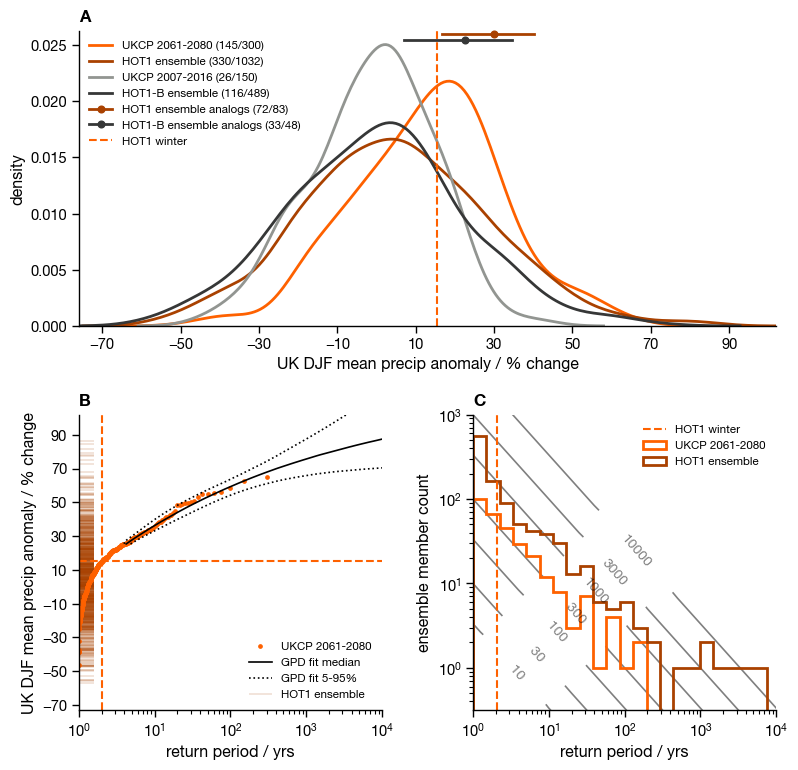

In [22]:
fig=create_main_fig('fut_2066','prm',statmodel=LMoments.gpd)

fig.dpi=100

[fig.savefig('../output/figs/SI/FIGS5.'+x,bbox_inches='tight',dpi=600) for x in ['png','pdf']]
''

''

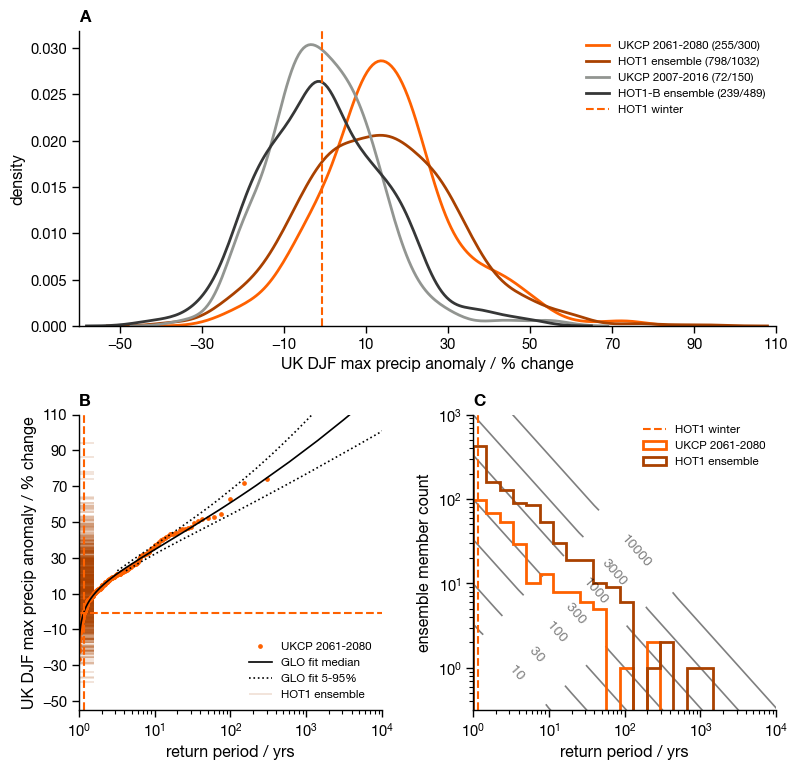

In [23]:
fig=create_main_fig('fut_2066','prx',statmodel=LMoments.glo)

fig.dpi=100

[fig.savefig('../output/figs/SI/FIGS10.'+x,bbox_inches='tight',dpi=600) for x in ['png','pdf']]
''

/home/users/njleach/mystatsfunctions/mystatsfunctions/LMoments.py:438: RuntimeWarning: invalid value encountered in power
  cdf = 1 - ( 1 - self.k*(x-self.X)/self.a )**(1/self.k)
<ipython-input-20-de288106e862>:106: RuntimeWarning: divide by zero encountered in true_divide
  rp_ax.semilogx(1/(1-np.median(UKCP_statmodel_CDF,axis=1))/(1-gpd_threshold),UKCP_statmodel_xrange,'k',label=str.upper(str(statmodel)[-5:-2])+' fit median')
/home/users/njleach/mystatsfunctions/mystatsfunctions/LMoments.py:438: RuntimeWarning: invalid value encountered in power
  cdf = 1 - ( 1 - self.k*(x-self.X)/self.a )**(1/self.k)


''

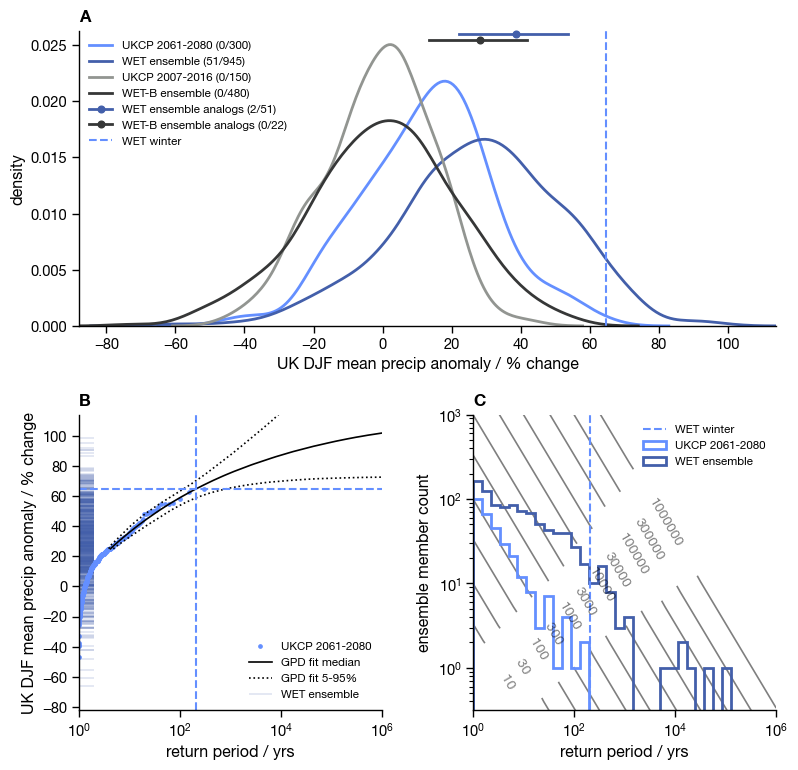

In [50]:
fig=create_main_fig('fut_2068','prm',statmodel=LMoments.gpd)

fig.dpi=100

[fig.savefig('../output/figs/FIG5.'+x,bbox_inches='tight',dpi=600) for x in ['png','pdf']]
''

''

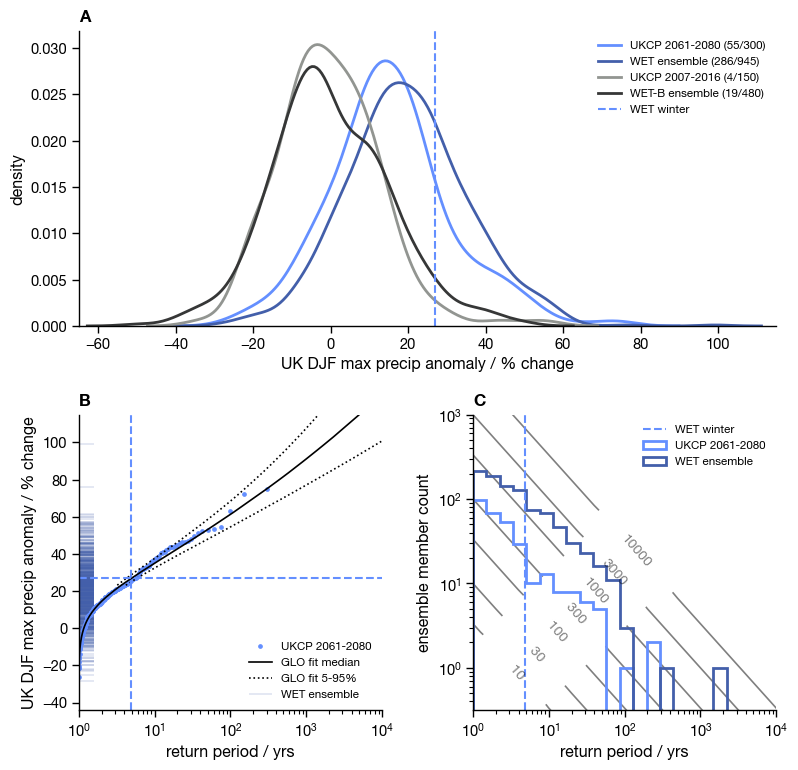

In [25]:
fig=create_main_fig('fut_2068','prx',statmodel=LMoments.glo)

fig.dpi=100

[fig.savefig('../output/figs/SI/FIGS12.'+x,bbox_inches='tight',dpi=600) for x in ['png','pdf']]
''

/home/users/njleach/mystatsfunctions/mystatsfunctions/LMoments.py:438: RuntimeWarning: invalid value encountered in power
  cdf = 1 - ( 1 - self.k*(x-self.X)/self.a )**(1/self.k)
<ipython-input-20-de288106e862>:106: RuntimeWarning: divide by zero encountered in true_divide
  rp_ax.semilogx(1/(1-np.median(UKCP_statmodel_CDF,axis=1))/(1-gpd_threshold),UKCP_statmodel_xrange,'k',label=str.upper(str(statmodel)[-5:-2])+' fit median')


''

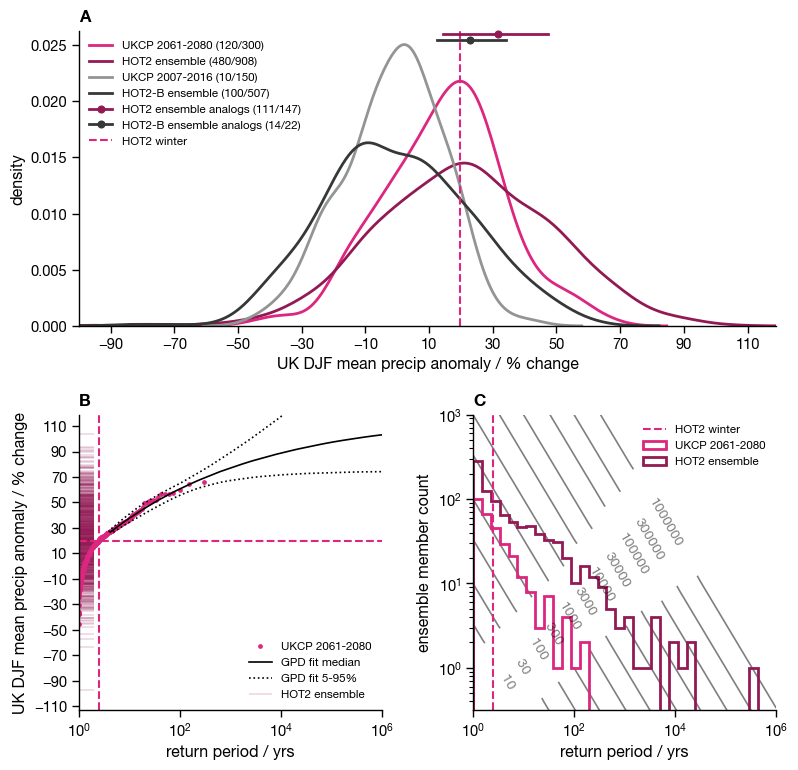

In [26]:
fig=create_main_fig('fut_2072','prm',statmodel=LMoments.gpd)

fig.dpi=100

[fig.savefig('../output/figs/SI/FIGS6.'+x,bbox_inches='tight',dpi=600) for x in ['png','pdf']]
''

''

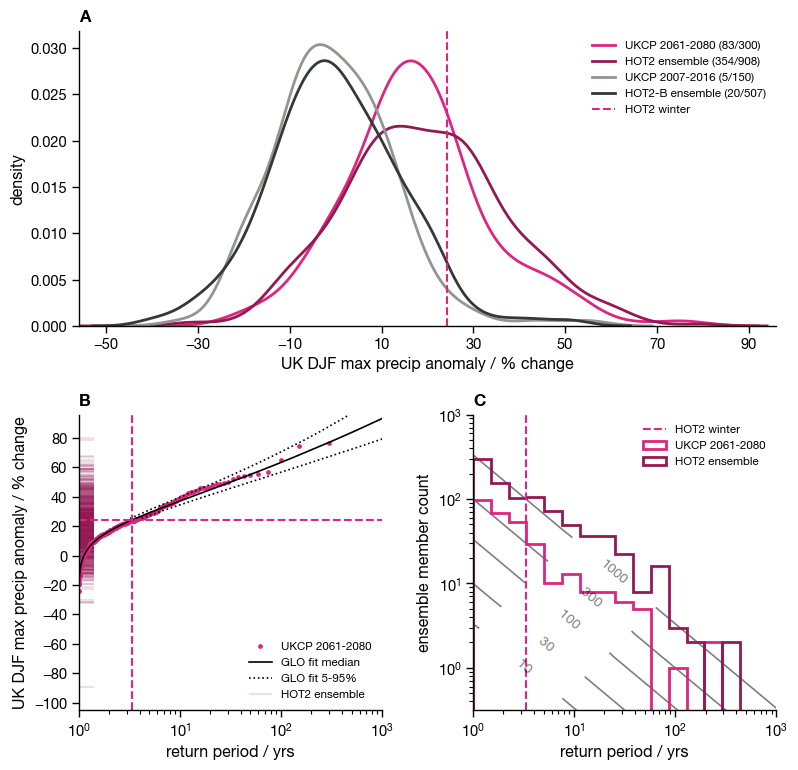

In [27]:
fig=create_main_fig('fut_2072','prx',statmodel=LMoments.glo)

fig.dpi=100

[fig.savefig('../output/figs/SI/FIGS11.'+x,bbox_inches='tight',dpi=600) for x in ['png','pdf']]
''

## Statistical comparison of ensembles

#### Absolute number of extremes sampled higher than the highest magnitude UKCP18 extreme

In [28]:
greater_extremes = 0

for select_winter in run_info.index:
    UKCP_fut_pop, UKCP_base_pop, ExS_fut_pop, ExS_base_pop = preproc_data_for_fig(select_winter,var='prm',percent=True)
    greater_extremes += (ExS_fut_pop>UKCP_fut_pop.max()).sum()
    
print('number of prm extremes that exceed the greatest in UKCP18:',greater_extremes)

number of prm extremes that exceed the greatest in UKCP18: 106


In [29]:
greater_extremes = 0

for select_winter in run_info.index:
    UKCP_fut_pop, UKCP_base_pop, ExS_fut_pop, ExS_base_pop = preproc_data_for_fig(select_winter,var='prx',percent=True)
    greater_extremes += (ExS_fut_pop>UKCP_fut_pop.max()).sum()
    
print('number of prx extremes that exceed the greatest in UKCP18:',greater_extremes)

number of prx extremes that exceed the greatest in UKCP18: 8


#### Extreme conditioning
Fraction of ExSamples over UKCP18 90/95/99th percentiles.

In [30]:
### write definition for carrying out the computating automatically

def get_extreme_fraction(select_winter,var='prm',percent=True,statmodel=LMoments.gpd,quantiles=[0.9,0.95,0.99]):
    
    ## select_winter is one of [fut_2066, fut_2068, fut_2072]
    
    ensmem,year,run,extreme,label = run_info.loc[select_winter].values
    
    UKCP_fut_pop, UKCP_base_pop, ExS_fut_pop, ExS_base_pop, ExS_fut_pop_analogs, ExS_base_pop_analogs = preproc_data_for_fig(select_winter,var=var,percent=percent,analogs=True)
    
    UKCP_selected_winter = UKCP_df.loc[int(year),(var,run[-4:])] - UKCP_df.loc[1997:2026,(var,run[-4:])].mean()
    
    if statmodel == LMoments.gpd:
        
        gpd_threshold = 0.75
        
    else:
        
        gpd_threshold = 0
    
    ## bootstrap the statistical model for 5-95 curves
    n_boot=10000
    
    ## create bootstrap samples + select members above quantile selected
    UKCP_fut_pop_boot = UKCP_fut_pop[np.random.choice(UKCP_fut_pop.size,UKCP_fut_pop.size*n_boot)].reshape(UKCP_fut_pop.size,-1)
    UKCP_fut_pop_boot = np.take_along_axis(UKCP_fut_pop_boot,UKCP_fut_pop_boot.argsort(axis=0),axis=0)[-int(np.ceil(UKCP_fut_pop_boot.shape[0]*(1-gpd_threshold))):]

    ## initialise a new distribution object
    UKCP_statmodel_boot = statmodel()
    ## and fit to each resample
    UKCP_statmodel_boot.fit(UKCP_fut_pop_boot)
    
    UKCP_extreme_threshold = np.array([UKCP_statmodel_boot.qf((quantile-gpd_threshold)/(1-gpd_threshold)).flatten() for quantile in quantiles])
    
    results = pd.DataFrame(columns=pd.MultiIndex.from_product([quantiles,[0.05,0.5,0.95]],names=['extreme quantile','unc quantile']))
    
    results.loc['ExS fut'] = np.nanquantile((ExS_fut_pop[:,None,None]>np.array([UKCP_statmodel_boot.qf((quantile-gpd_threshold)/(1-gpd_threshold)).flatten() for quantile in quantiles])[None]).sum(axis=0),[0.05,0.5,0.95],axis=1).T.flatten()/ExS_fut_pop.size
    results.loc['ExS fut analogs'] = np.nanquantile((ExS_fut_pop_analogs[:,None,None]>np.array([UKCP_statmodel_boot.qf((quantile-gpd_threshold)/(1-gpd_threshold)).flatten() for quantile in quantiles])[None]).sum(axis=0),[0.05,0.5,0.95],axis=1).T.flatten()/ExS_fut_pop_analogs.size
    results.loc['UKCP fut'] = np.nanquantile((UKCP_fut_pop[:,None,None]>np.array([UKCP_statmodel_boot.qf((quantile-gpd_threshold)/(1-gpd_threshold)).flatten() for quantile in quantiles])[None]).sum(axis=0),[0.05,0.5,0.95],axis=1).T.flatten()/UKCP_fut_pop.size
    
    results.loc['ExS - UKCP RR'] = np.nanquantile((ExS_fut_pop[:,None,None]>np.array([UKCP_statmodel_boot.qf((quantile-gpd_threshold)/(1-gpd_threshold)).flatten() for quantile in quantiles])[None]).sum(axis=0)/(UKCP_fut_pop[:,None,None]>np.array([UKCP_statmodel_boot.qf((quantile-gpd_threshold)/(1-gpd_threshold)).flatten() for quantile in quantiles])[None]).sum(axis=0)*UKCP_fut_pop.size/ExS_fut_pop.size,[0.05,0.5,0.95],axis=1).T.flatten()
    
    # print out the results for the manuscript table
    [print(quantile,': ',results.loc['ExS - UKCP RR',(quantile,0.5)].round(2),' [',results.loc['ExS - UKCP RR',(quantile,0.05)].round(2),' , ',results.loc['ExS - UKCP RR',(quantile,0.95)].round(2),']',sep='') for quantile in quantiles]
    
    return results.round(3)

In [31]:
get_extreme_fraction('fut_2066','prm',percent=True,statmodel=LMoments.gpd)

0.9: 1.02 [0.95 , 1.08]
0.95: 0.98 [0.85 , 1.02]
0.99: 2.03 [1.0 , 3.78]


<ipython-input-30-912daa6d55e2>:41: RuntimeWarning: divide by zero encountered in true_divide
  results.loc['ExS - UKCP RR'] = np.nanquantile((ExS_fut_pop[:,None,None]>np.array([UKCP_statmodel_boot.qf((quantile-gpd_threshold)/(1-gpd_threshold)).flatten() for quantile in quantiles])[None]).sum(axis=0)/(UKCP_fut_pop[:,None,None]>np.array([UKCP_statmodel_boot.qf((quantile-gpd_threshold)/(1-gpd_threshold)).flatten() for quantile in quantiles])[None]).sum(axis=0)*UKCP_fut_pop.size/ExS_fut_pop.size,[0.05,0.5,0.95],axis=1).T.flatten()


extreme quantile   0.90                 0.95                 0.99         \
unc quantile       0.05   0.50   0.95   0.05   0.50   0.95   0.05   0.50   
ExS fut           0.075  0.099  0.120  0.040  0.054  0.075  0.013  0.016   
ExS fut analogs   0.181  0.325  0.410  0.108  0.145  0.181  0.036  0.060   
UKCP fut          0.073  0.097  0.127  0.050  0.053  0.073  0.003  0.007   
ExS - UKCP RR     0.951  1.017  1.076  0.848  0.978  1.017  0.997  2.035   

extreme quantile         
unc quantile       0.95  
ExS fut           0.024  
ExS fut analogs   0.060  
UKCP fut          0.023  
ExS - UKCP RR     3.779

In [32]:
get_extreme_fraction('fut_2066','prx',percent=True,statmodel=LMoments.glo)

0.9: 1.02 [0.91 , 1.14]
0.95: 0.9 [0.84 , 1.06]
0.99: 0.97 [0.73 , 1.84]


<ipython-input-30-912daa6d55e2>:41: RuntimeWarning: divide by zero encountered in true_divide
  results.loc['ExS - UKCP RR'] = np.nanquantile((ExS_fut_pop[:,None,None]>np.array([UKCP_statmodel_boot.qf((quantile-gpd_threshold)/(1-gpd_threshold)).flatten() for quantile in quantiles])[None]).sum(axis=0)/(UKCP_fut_pop[:,None,None]>np.array([UKCP_statmodel_boot.qf((quantile-gpd_threshold)/(1-gpd_threshold)).flatten() for quantile in quantiles])[None]).sum(axis=0)*UKCP_fut_pop.size/ExS_fut_pop.size,[0.05,0.5,0.95],axis=1).T.flatten()


extreme quantile   0.90                 0.95                 0.99         \
unc quantile       0.05   0.50   0.95   0.05   0.50   0.95   0.05   0.50   
ExS fut           0.089  0.113  0.145  0.046  0.055  0.078  0.005  0.008   
ExS fut analogs   0.145  0.193  0.265  0.096  0.096  0.120  0.000  0.012   
UKCP fut          0.097  0.110  0.133  0.043  0.063  0.083  0.007  0.010   
ExS - UKCP RR     0.911  1.017  1.137  0.836  0.899  1.059  0.727  0.969   

extreme quantile         
unc quantile       0.95  
ExS fut           0.019  
ExS fut analogs   0.048  
UKCP fut          0.013  
ExS - UKCP RR     1.841

In [33]:
get_extreme_fraction('fut_2068','prm',percent=True,statmodel=LMoments.gpd)

0.9: 3.96 [3.42 , 4.23]
0.95: 4.7 [4.22 , 4.94]
0.99: 11.75 [6.17 , 17.14]


<ipython-input-30-912daa6d55e2>:41: RuntimeWarning: divide by zero encountered in true_divide
  results.loc['ExS - UKCP RR'] = np.nanquantile((ExS_fut_pop[:,None,None]>np.array([UKCP_statmodel_boot.qf((quantile-gpd_threshold)/(1-gpd_threshold)).flatten() for quantile in quantiles])[None]).sum(axis=0)/(UKCP_fut_pop[:,None,None]>np.array([UKCP_statmodel_boot.qf((quantile-gpd_threshold)/(1-gpd_threshold)).flatten() for quantile in quantiles])[None]).sum(axis=0)*UKCP_fut_pop.size/ExS_fut_pop.size,[0.05,0.5,0.95],axis=1).T.flatten()


extreme quantile   0.90                 0.95                 0.99          \
unc quantile       0.05   0.50   0.95   0.05   0.50   0.95   0.05    0.50   
ExS fut           0.317  0.380  0.431  0.213  0.255  0.317  0.057   0.092   
ExS fut analogs   0.471  0.529  0.588  0.333  0.392  0.471  0.059   0.118   
UKCP fut          0.073  0.097  0.127  0.047  0.053  0.073  0.003   0.007   
ExS - UKCP RR     3.417  3.958  4.228  4.218  4.702  4.940  6.168  11.746   

extreme quantile          
unc quantile        0.95  
ExS fut            0.145  
ExS fut analogs    0.176  
UKCP fut           0.023  
ExS - UKCP RR     17.143

In [34]:
get_extreme_fraction('fut_2068','prx',percent=True,statmodel=LMoments.glo)

0.9: 1.46 [1.3 , 1.56]
0.95: 1.19 [1.09 , 1.34]
0.99: 0.32 [0.21 , 1.59]


<ipython-input-30-912daa6d55e2>:41: RuntimeWarning: divide by zero encountered in true_divide
  results.loc['ExS - UKCP RR'] = np.nanquantile((ExS_fut_pop[:,None,None]>np.array([UKCP_statmodel_boot.qf((quantile-gpd_threshold)/(1-gpd_threshold)).flatten() for quantile in quantiles])[None]).sum(axis=0)/(UKCP_fut_pop[:,None,None]>np.array([UKCP_statmodel_boot.qf((quantile-gpd_threshold)/(1-gpd_threshold)).flatten() for quantile in quantiles])[None]).sum(axis=0)*UKCP_fut_pop.size/ExS_fut_pop.size,[0.05,0.5,0.95],axis=1).T.flatten()


extreme quantile   0.90                 0.95                 0.99         \
unc quantile       0.05   0.50   0.95   0.05   0.50   0.95   0.05   0.50   
ExS fut           0.126  0.161  0.204  0.050  0.074  0.114  0.002  0.003   
ExS fut analogs   0.118  0.137  0.216  0.098  0.118  0.118  0.000  0.000   
UKCP fut          0.097  0.110  0.133  0.043  0.063  0.083  0.007  0.010   
ExS - UKCP RR     1.303  1.464  1.559  1.093  1.190  1.343  0.212  0.317   

extreme quantile         
unc quantile       0.95  
ExS fut           0.018  
ExS fut analogs   0.039  
UKCP fut          0.013  
ExS - UKCP RR     1.587

In [35]:
get_extreme_fraction('fut_2072','prm',percent=True,statmodel=LMoments.gpd)

0.9: 2.93 [2.5 , 3.22]
0.95: 3.6 [3.17 , 3.81]
0.99: 10.08 [4.48 , 16.19]


<ipython-input-30-912daa6d55e2>:41: RuntimeWarning: divide by zero encountered in true_divide
  results.loc['ExS - UKCP RR'] = np.nanquantile((ExS_fut_pop[:,None,None]>np.array([UKCP_statmodel_boot.qf((quantile-gpd_threshold)/(1-gpd_threshold)).flatten() for quantile in quantiles])[None]).sum(axis=0)/(UKCP_fut_pop[:,None,None]>np.array([UKCP_statmodel_boot.qf((quantile-gpd_threshold)/(1-gpd_threshold)).flatten() for quantile in quantiles])[None]).sum(axis=0)*UKCP_fut_pop.size/ExS_fut_pop.size,[0.05,0.5,0.95],axis=1).T.flatten()


extreme quantile   0.90                 0.95                 0.99          \
unc quantile       0.05   0.50   0.95   0.05   0.50   0.95   0.05    0.50   
ExS fut           0.247  0.280  0.314  0.156  0.202  0.244  0.054   0.078   
ExS fut analogs   0.279  0.347  0.429  0.150  0.197  0.272  0.034   0.068   
UKCP fut          0.077  0.097  0.127  0.050  0.053  0.073  0.003   0.007   
ExS - UKCP RR     2.504  2.928  3.221  3.172  3.595  3.811  4.484  10.077   

extreme quantile          
unc quantile        0.95  
ExS fut            0.105  
ExS fut analogs    0.088  
UKCP fut           0.023  
ExS - UKCP RR     16.189

In [36]:
get_extreme_fraction('fut_2072','prx',percent=True,statmodel=LMoments.glo)

0.9: 1.4 [1.31 , 1.46]
0.95: 1.31 [1.19 , 1.39]
0.99: 0.66 [0.33 , 2.09]


<ipython-input-30-912daa6d55e2>:41: RuntimeWarning: divide by zero encountered in true_divide
  results.loc['ExS - UKCP RR'] = np.nanquantile((ExS_fut_pop[:,None,None]>np.array([UKCP_statmodel_boot.qf((quantile-gpd_threshold)/(1-gpd_threshold)).flatten() for quantile in quantiles])[None]).sum(axis=0)/(UKCP_fut_pop[:,None,None]>np.array([UKCP_statmodel_boot.qf((quantile-gpd_threshold)/(1-gpd_threshold)).flatten() for quantile in quantiles])[None]).sum(axis=0)*UKCP_fut_pop.size/ExS_fut_pop.size,[0.05,0.5,0.95],axis=1).T.flatten()


extreme quantile   0.90                 0.95                 0.99         \
unc quantile       0.05   0.50   0.95   0.05   0.50   0.95   0.05   0.50   
ExS fut           0.128  0.154  0.189  0.052  0.085  0.112  0.002  0.007   
ExS fut analogs   0.136  0.184  0.231  0.048  0.082  0.109  0.007  0.014   
UKCP fut          0.097  0.110  0.133  0.043  0.063  0.083  0.007  0.010   
ExS - UKCP RR     1.310  1.399  1.458  1.195  1.305  1.388  0.330  0.661   

extreme quantile         
unc quantile       0.95  
ExS fut           0.025  
ExS fut analogs   0.034  
UKCP fut          0.013  
ExS - UKCP RR     2.093

#### K-S statistics

In [37]:
def get_ks_stats(A,B):
    stat1=sp.stats.ks_2samp(B,A,alternative='greater').statistic
    stat2=sp.stats.ks_2samp(B,A,alternative='less').statistic
    stat3=sp.stats.ks_2samp(B,A,alternative='two-sided').pvalue
    return stat1,stat2,stat3

def ks_stat_results(select_winter,var='prm',percent=False,analogs=False):
    
    if analogs:
        UKCP_fut_pop, UKCP_base_pop, ExS_fut_pop, ExS_base_pop, ExS_fut_pop_analogs, ExS_base_pop_analogs = preproc_data_for_fig(select_winter,var,percent,analogs=True)
    else:
        UKCP_fut_pop, UKCP_base_pop, ExS_fut_pop, ExS_base_pop = preproc_data_for_fig(select_winter,var,percent)
    
    results = pd.DataFrame(columns=['greater','less','P(H0:A==B)'])
    results.columns.name='H1'
    
    results.loc['ExS future - ExS base'] = get_ks_stats(ExS_fut_pop,ExS_base_pop)
    results.loc['UKCP future - UKCP base'] = get_ks_stats(UKCP_fut_pop,UKCP_base_pop)
    results.loc['ExS future - UKCP future'] = get_ks_stats(ExS_fut_pop,UKCP_fut_pop)
    results.loc['ExS base - UKCP base'] = get_ks_stats(ExS_base_pop,UKCP_base_pop)
    if analogs:
        results.loc['ExS future analogs - ExS future'] = get_ks_stats(ExS_fut_pop_analogs,ExS_fut_pop)
        results.loc['ExS base analogs - ExS base'] = get_ks_stats(ExS_base_pop_analogs,ExS_base_pop)
    
    return results.round(3)

In [38]:
print('02868 - 2066 - hot : prm')
ks_stat_results('fut_2066',var='prm',percent=True,analogs=True)

02868 - 2066 - hot : prm


H1,greater,less,P(H0:A==B)
ExS future - ExS base,0.105,0.000,0.001
UKCP future - UKCP base,0.370,0.007,0.000
ExS future - UKCP future,0.012,0.212,0.000
ExS base - UKCP base,0.116,0.089,0.083
ExS future analogs - ExS future,0.548,0.005,0.000
ExS base analogs - ExS base,0.500,0.004,0.000


In [39]:
print('02868 - 2066 - hot : prx')
ks_stat_results('fut_2066',var='prx',percent=True)

02868 - 2066 - hot : prx


H1,greater,less,P(H0:A==B)
ExS future - ExS base,0.320,0.000,0.000
UKCP future - UKCP base,0.463,0.000,0.000
ExS future - UKCP future,0.056,0.125,0.001
ExS base - UKCP base,0.086,0.094,0.248


In [40]:
print('02242 - 2068 - wet : prm')
ks_stat_results('fut_2068',var='prm',percent=True,analogs=True)

02242 - 2068 - wet : prm


/home/users/njleach/miniconda3/lib/python3.9/site-packages/scipy/stats/stats.py:6516: RuntimeWarning: overflow encountered in double_scalars
  num_paths += term
/home/users/njleach/miniconda3/lib/python3.9/site-packages/scipy/stats/stats.py:6513: RuntimeWarning: overflow encountered in double_scalars
  term = B[j] * bin


H1,greater,less,P(H0:A==B)
ExS future - ExS base,0.490,0.000,0.000
UKCP future - UKCP base,0.363,0.007,0.000
ExS future - UKCP future,0.336,0.004,0.000
ExS base - UKCP base,0.127,0.070,0.045
ExS future analogs - ExS future,0.257,0.033,0.003
ExS base analogs - ExS base,0.654,0.000,0.000


In [41]:
print('02242 - 2068 - wet : prx')
ks_stat_results('fut_2068',var='prx',percent=True)

02242 - 2068 - wet : prx


/home/users/njleach/miniconda3/lib/python3.9/site-packages/scipy/stats/stats.py:6516: RuntimeWarning: overflow encountered in double_scalars
  num_paths += term
/home/users/njleach/miniconda3/lib/python3.9/site-packages/scipy/stats/stats.py:6513: RuntimeWarning: overflow encountered in double_scalars
  term = B[j] * bin


H1,greater,less,P(H0:A==B)
ExS future - ExS base,0.503,0.000,0.000
UKCP future - UKCP base,0.480,0.000,0.000
ExS future - UKCP future,0.158,0.008,0.000
ExS base - UKCP base,0.075,0.067,0.516


In [42]:
print('01554 - 2072 - hot : prm')
ks_stat_results('fut_2072',var='prm',percent=True,analogs=True)

01554 - 2072 - hot : prm


H1,greater,less,P(H0:A==B)
ExS future - ExS base,0.339,0.001,0.000
UKCP future - UKCP base,0.393,0.003,0.000
ExS future - UKCP future,0.195,0.032,0.000
ExS base - UKCP base,0.147,0.110,0.012
ExS future analogs - ExS future,0.263,0.030,0.000
ExS base analogs - ExS base,0.566,0.014,0.000


In [43]:
print('01554 - 2072 - hot : prx')
ks_stat_results('fut_2072',var='prx',percent=True)

01554 - 2072 - hot : prx


/home/users/njleach/miniconda3/lib/python3.9/site-packages/scipy/stats/stats.py:6513: RuntimeWarning: overflow encountered in double_scalars
  term = B[j] * bin


H1,greater,less,P(H0:A==B)
ExS future - ExS base,0.466,0.001,0.000
UKCP future - UKCP base,0.547,0.000,0.000
ExS future - UKCP future,0.124,0.043,0.002
ExS base - UKCP base,0.064,0.051,0.706


Comparison of all ExSamples baseline members with UKCP18 PPE:

In [44]:
UKCP_base_pop = preproc_data_for_fig('fut_2066','prm',percent=True)[1]
ExS_base_pop = np.concatenate([preproc_data_for_fig(select_winter,'prm',percent=True)[3] for select_winter in run_info.index])

results = pd.DataFrame(columns=['greater','less','P(H0:A==B)'])
results.columns.name='H1'
results.loc['ExS base - UKCP base'] = get_ks_stats(ExS_base_pop,UKCP_base_pop)

results.round(3)

H1,greater,less,P(H0:A==B)
ExS base - UKCP base,0.13,0.089,0.018


In [45]:
UKCP_base_pop = preproc_data_for_fig('fut_2066','prx',percent=True)[1]
ExS_base_pop = np.concatenate([preproc_data_for_fig(select_winter,'prx',percent=True)[3] for select_winter in run_info.index])

results = pd.DataFrame(columns=['greater','less','P(H0:A==B)'])
results.columns.name='H1'
results.loc['ExS base - UKCP base'] = get_ks_stats(ExS_base_pop,UKCP_base_pop)

results.round(3)

H1,greater,less,P(H0:A==B)
ExS base - UKCP base,0.075,0.07,0.41


Comparison between ExSamples baseline ensembles:

In [46]:
ExS_base_pop = [preproc_data_for_fig(select_winter,'prm',percent=True)[3] for select_winter in run_info.index]

results = pd.DataFrame(columns=['greater','less','P(H0:A==B)'])
results.columns.name='H1'
results.loc['1554 - 2242'] = get_ks_stats(ExS_base_pop[0],ExS_base_pop[1])
results.loc['1554 - 2868'] = get_ks_stats(ExS_base_pop[0],ExS_base_pop[2])
results.loc['2242 - 2868'] = get_ks_stats(ExS_base_pop[1],ExS_base_pop[2])

results.round(3)

H1,greater,less,P(H0:A==B)
1554 - 2242,0.036,0.058,0.349
1554 - 2868,0.047,0.051,0.504
2242 - 2868,0.040,0.027,0.813


In [47]:
ExS_base_pop = [preproc_data_for_fig(select_winter,'prx',percent=True)[3] for select_winter in run_info.index]

results = pd.DataFrame(columns=['greater','less','P(H0:A==B)'])
results.columns.name='H1'
results.loc['1554 - 2242'] = get_ks_stats(ExS_base_pop[0],ExS_base_pop[1])
results.loc['1554 - 2868'] = get_ks_stats(ExS_base_pop[0],ExS_base_pop[2])
results.loc['2242 - 2868'] = get_ks_stats(ExS_base_pop[1],ExS_base_pop[2])

results.round(3)

H1,greater,less,P(H0:A==B)
1554 - 2242,0.036,0.029,0.881
1554 - 2868,0.049,0.042,0.558
2242 - 2868,0.037,0.035,0.878


### Difference in rainfall intensity over baselines

In [48]:
print('UKCP18 PPE baseline DJF mean rainfall intensity:',UKCP_df.loc[2007:2016,'prm'].values.mean())
print('ExSamples ALL baseline DJF mean rainfall intensity:',ExS_base.prm.values.mean(),'\n')

print('UKCP18 PPE baseline DJF mean max rainfall intensity:',UKCP_df.loc[2007:2016,'prx'].values.mean())
print('ExSamples ALL baseline DJF max rainfall intensity:',ExS_base.prx.values.mean())

UKCP18 PPE baseline DJF mean rainfall intensity: 3.7562988
ExSamples ALL baseline DJF mean rainfall intensity: 3.145601 

UKCP18 PPE baseline DJF mean max rainfall intensity: 25.324787
ExSamples ALL baseline DJF max rainfall intensity: 24.336142


''

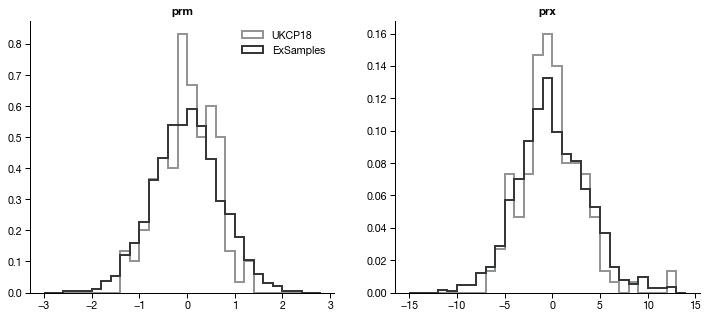

In [49]:
fig,ax = plt.subplots(1,2,figsize=(12,5))

bins={'prm':np.arange(-3,3,0.2),'prx':np.arange(-15,15,1)}

for i,var in enumerate(['prm','prx']):
    ax[i].hist((UKCP_df.loc[2007:2016,var] - UKCP_df.loc[2007:2016,var].mean()).values.flatten(),bins=bins[var],histtype='step',density=True,label='UKCP18',color='xkcd:grey',lw=2)
    ax[i].hist((ExS_base[var]-ExS_base[var].groupby(level=0).transform('mean')).values.flatten(),bins=bins[var],histtype='step',density=True,label='ExSamples',color='xkcd:dark grey',lw=2)
    
    ax[i].set_title(var,fontweight='bold')

ax[0].legend(frameon=False)
sn.despine()
''